In [1]:
from mne import io

from pathlib import Path
import numpy as np
import pandas as pd

from pathlib import Path
import numpy as np
import pandas as pd
import mne

from mne.viz import plot_compare_evokeds
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

In [2]:
sessions = ["ses-EMS", "ses-Vibro", "ses-Visual"]
subjects = ['sub-13',
        'sub-14',
        'sub-15',
        # 'sub-12',
        'sub-08',
        'sub-06',
        'sub-07',
        'sub-11',
        'sub-16',
        'sub-02']


base_path = Path("/Users/Milana/Documents/university/eeg_block/prediction_error_EEG/ds003846-2.0.2")

ica_sessions = {s: [] for s in sessions}
session2event = {s: [] for s in sessions}
event_id = {"normal": 2, "conflict": 3}


for session in sessions:
    for subject in subjects:
        # load the dataset
        data = io.read_raw_fif(f"/Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/{subject}/{session}_processed_raw.fif")
        ica_sessions[session].append(data)

        events_file = base_path / subject / session / "eeg" /f"{subject}_{session}_task-PredictionError_events.tsv"
        events_df = pd.read_csv(events_file, sep="\t")

        # Map events
        events = []
        for _, row in events_df.iterrows():
            event_dict = dict(item.split(":") for item in row["value"].split(";"))

            if "box" in event_dict and event_dict["box"] == "touched":
                sample = int(row["sample"])
                onset_in_sec = float(row["onset"])
                sample_index = int(round(onset_in_sec * data.info["sfreq"]))

                events.append([sample_index, 0, event_id[event_dict["normal_or_conflict"]]])
        
        session2event[session].append(np.array(events))

Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/sub-13/ses-EMS_processed_raw.fif...
    Range : 0 ... 183917 =      0.000 ...   735.668 secs
Ready.
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/sub-14/ses-EMS_processed_raw.fif...
    Range : 0 ... 195397 =      0.000 ...   781.588 secs
Ready.
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/sub-15/ses-EMS_processed_raw.fif...
    Range : 0 ... 171767 =      0.000 ...   687.068 secs
Ready.
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/sub-08/ses-EMS_processed_raw.fif...
    Range : 0 ... 168387 =      0.000 ...   673.548 secs
Ready.
Opening raw data file /Users/Milana/Documents/university/eeg_block/multivariate_data/processed_2/sub-06/ses-EMS_processed_raw.fif...
    Range : 0 ... 173681 =      0.000 ...   694.724 secs
Ready.
Opening raw dat

In [3]:
ica_sessions_processed = {}

for k, events in ica_sessions.items():
    ica_sessions_processed[k] = mne.concatenate_raws(events)

In [4]:
for s in session2event:
    session2event[s] = np.concatenate(session2event[s])

In [5]:
epochs_sessions = {}
tmin, tmax = -0.3, 0.7
event_id = {"normal": 2, "conflict": 3}

for session, raw in ica_sessions_processed.items():
    print(f"Creating stimulus-aligned epochs for {session}...")

    events = session2event[session]

    epochs = mne.Epochs(
        raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
        baseline=(None, 0), preload=True, event_repeated="drop"
    )
    epochs_sessions[session] = epochs
    print(f"Extracted {len(epochs)} epochs for {session}.")

Creating stimulus-aligned epochs for ses-EMS...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
1853 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1853 events and 251 original time points ...
0 bad epochs dropped
Extracted 1853 epochs for ses-EMS.
Creating stimulus-aligned epochs for ses-Vibro...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
3104 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3104 events and 251 original time points ...
0 bad epochs dropped
Extracted 3104 epochs for ses-Vibro.
Creating stimulus-aligned epochs for ses-Visual...
Multiple event values for single event times found. Keeping the first occurre

**Epoch Rejection (Step 7)**

Following the paper, we reject the 10% noisiest epochs. 

In [6]:
for session, epochs in epochs_sessions.items():
    peak_to_peak = np.ptp(epochs.get_data(), axis=2).mean(axis=1)

    # Find the 10% noisiest epochs
    threshold = np.percentile(peak_to_peak, 80)  # 90th percentile
    noisy_epochs = peak_to_peak > threshold

    # Drop the noisiest epochs
    epochs.drop(indices=np.where(noisy_epochs)[0], reason='manual')

Dropped 370 epochs: 0, 1, 2, 3, 4, 5, 114, 115, 116, 136, 137, 189, 190, 191, 192, 225, 226, 227, 228, 263, 264, 265, 266, 267, 276, 277, 278, 279, 300, 301, 302, 303, 304, 305, 308, 309, 310, 311, 430, 431, 447, 448, 449, 450, 467, 468, 469, 470, 505, 506, 561, 562, 563, 580, 581, 600, 601, 616, 617, 618, 619, 772, 773, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 798, 799, 800, 801, 802, 803, 804, 805, 806, 811, 812, 813, 814, 831, 832, 833, 834, 835, 836, 847, 848, 849, 850, 851, 852, 855, 856, 857, 858, 866, 867, 868, 869, 870, 871, 872, 873, 874, 875, 884, 885, 886, 890, 891, 892, 893, 894, 895, 896, 897, 898, 899, 912, 913, 914, 915, 922, 923, 924, 925, 926, 927, 932, 933, 934, 935, 956, 957, 958, 959, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 986, 987, 988, 989, 990, 991, 992, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1017, 1018, 1019, 1020, 1049, 1050, 1051, 1052, 1093, 1094, 1095, 1096, 1097, 1098, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1136, 1139, 1140, 

**ERP Analysis (step 8)**

In [8]:
evokeds_normal = {}
evokeds_conflict = {}
evokeds_difference = {}

for session, epochs in epochs_sessions.items():
    # Apply a 10 Hz low-pass filter to the epochs
    epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)

    # Average each condition at FCz
    evoked_normal = epochs_filtered["normal"].average(picks="FCz")
    evoked_conflict = epochs_filtered["conflict"].average(picks="FCz")

    # Calculate the difference (Conflict - Normal)
    evoked_diff = evoked_conflict.copy()
    evoked_diff.data = evoked_conflict.data - evoked_normal.data

    # Store them by session name
    evokeds_normal[session] = evoked_normal
    evokeds_conflict[session] = evoked_conflict
    evokeds_difference[session] = evoked_diff

/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/4009931424.py:7: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/4009931424.py:7: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/4009931424.py:7: RuntimeWarning: filter_length (331) is longer than the signal (251), distortion is likely. Reduce filter length or filter a longer signal.
  epochs_filtered = epochs.filter(l_freq=None, h_freq=10, picks="all", verbose=False)


combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/3897532565.py:25: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/3897532565.py:34: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(
/var/folders/sx/cqhmbh993qdcxtbfnsqx7_rh0000gn/T/ipykernel_15705/3897532565.py:43: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  plot_compare_evokeds(


combining channels using "mean"


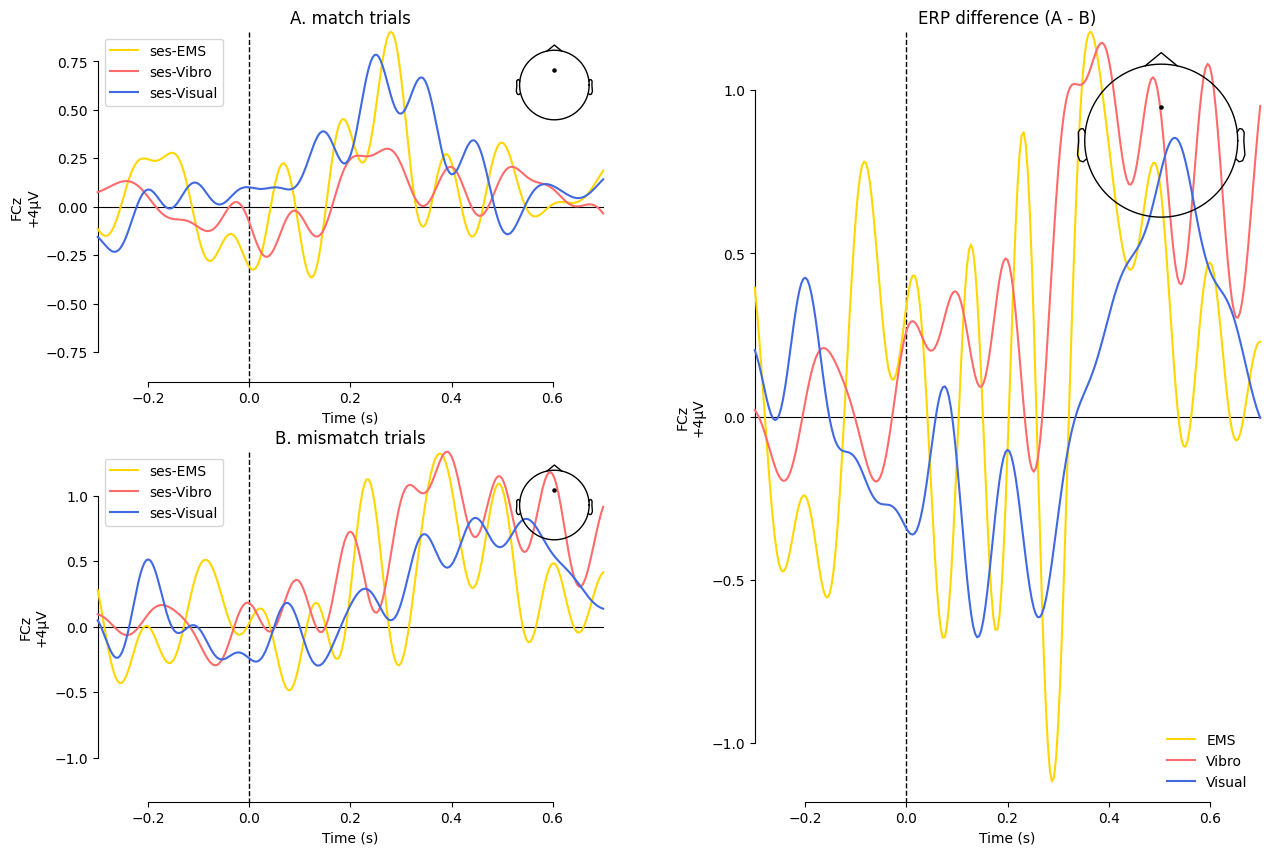

In [9]:
colors = {
    "ses-EMS": "#FFD700",     # Golden yellow
    "ses-Vibro": "#FF6B6B",   # Coral red
    "ses-Visual": "#4169E1"   # Royal blue
}

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Plot settings dictionary
plot_kwargs = dict(
    picks="FCz",
    combine="mean",
    ci=True,                    # Enable confidence intervals
    show=False,
    time_unit='s',             # Show time in seconds
    ylim=dict(FCz=[-4, 4]),    # Set y-axis limits
    vlines=[0],                # Add vertical line at time=0
)

# Plot normal trials
plot_compare_evokeds(
    evokeds_normal,
    axes=ax1,
    title="A. match trials",
    colors=colors,
    **plot_kwargs
)

# Plot conflict trials
plot_compare_evokeds(
    evokeds_conflict,
    axes=ax2,
    title="B. mismatch trials",
    colors=colors,
    **plot_kwargs
)

# Plot difference with larger size
plot_compare_evokeds(
    evokeds_difference,
    axes=ax3,
    title="ERP difference (A - B)",
    colors=colors,
    **plot_kwargs
)

# Adjust layout and styling
plt.subplots_adjust(wspace=0.3)

# Add labels and annotations
for ax in [ax1, ax2, ax3]:
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('FCz\n+4μV')
    
# Add legend at the bottom
ax3.legend(['EMS', 'Vibro', 'Visual'], 
          loc='lower right',
          frameon=False)

plt.show()